Modelo de Clasificación de Casos de Dengue

Objetivo
Construir un modelo de machine learning que prediga la categoría de casos de dengue por rangos usando LightGBM.


Paso 1: Importaciones y carga de datos


In [5]:
# Importaciones
!pip3 install pandas numpy matplotlib seaborn scikit-learn lightgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb

print("Todo instalado")



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Todo instalado


In [4]:
# Cargar datos
df = pd.read_csv('data-modelo.csv')

print(f"📊 Filas: {len(df):,}")
print(f"📋 Columnas: {len(df.columns)}")
print(f"\n🔍 Primeras 5 filas:")
df.head()


📊 Filas: 12,519
📋 Columnas: 38

🔍 Primeras 5 filas:


,id_uta,departamento_nombre,provincia_nombre,id_estacion,anio,semana,cantidad_casos,poblacion,temperatura_minima_lag1,temperatura_minima_lag2,...,tesion_vapor_media_lag3,radiacion_global_lag1,radiacion_global_lag2,radiacion_global_lag3,heliofania_efectiva_lag1,heliofania_efectiva_lag2,heliofania_efectiva_lag3,heliofania_relativa_lag1,heliofania_relativa_lag2,heliofania_relativa_lag3
0,2008,comuna 8,ciudad de buenos aires,A872810,2020,7,1.0,228953,21.042857,21.042857,...,23.412006,17.392447,17.392447,19.425206,6.938757,6.938757,7.937013,51.142857,51.142857,56.928571
1,2008,comuna 8,ciudad de buenos aires,A872810,2020,8,2.0,228953,17.695502,21.042857,...,24.017211,19.981907,17.392447,17.392447,7.841595,6.938757,6.938757,58.714286,51.142857,51.142857
2,2008,comuna 8,ciudad de buenos aires,A872810,2020,8,3.0,228953,14.612961,17.695502,...,24.017211,17.812327,19.981907,17.392447,6.905201,7.841595,6.938757,52.624060,58.714286,51.142857
3,2008,comuna 8,ciudad de buenos aires,A872810,2020,8,1.0,228953,14.612961,14.612961,...,18.818262,17.812327,17.812327,19.981907,6.905201,6.905201,7.841595,52.624060,52.624060,58.714286
4,2008,comuna 8,ciudad de buenos aires,A872810,2020,8,4.0,228953,14.612961,14.612961,...,15.009032,17.812327,17.812327,17.812327,6.905201,6.905201,6.905201,52.624060,52.624060,52.624060


In [7]:
# Información básica del dataset
print("=" * 60)
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"\n📅 Años: {df['anio'].min()} - {df['anio'].max()}")
print(f"📆 Semanas: {df['semana'].min()} - {df['semana'].max()}")
print(f"🏙️ Departamentos: {df['id_uta'].nunique()}")
print(f"🌍 Provincias: {df['provincia_nombre'].nunique()}")

print("\n" + "=" * 60)
print("CASOS DE DENGUE (cantidad_casos)")
print("=" * 60)
print(df['cantidad_casos'].describe())
print(f"\nTotal casos: {df['cantidad_casos'].sum():,.0f}")


INFORMACIÓN DEL DATASET

📅 Años: 2018 - 2025
📆 Semanas: 1 - 52
🏙️ Departamentos: 111
🌍 Provincias: 15

CASOS DE DENGUE (cantidad_casos)
count    12519.000000
mean        13.911495
std         31.427272
min          1.000000
25%          1.000000
50%          4.000000
75%         11.000000
max        433.000000
Name: cantidad_casos, dtype: float64

Total casos: 174,158


Paso 2: Analizar la distribución de casos para definir rangos

ANÁLISIS DE DISTRIBUCIÓN DE CASOS (INCLUYENDO CEROS)

🔍 Casos con 0 casos: 0 registros (0.0%)
🔍 Casos con >0 casos: 12,519 registros (100.0%)

📊 Estadísticas (incluyendo ceros):
count    12519.000000
mean        13.911495
std         31.427272
min          1.000000
25%          1.000000
50%          4.000000
75%         11.000000
max        433.000000
Name: cantidad_casos, dtype: float64

📈 Percentiles:
  10%: 1 casos
  25%: 1 casos
  50%: 4 casos
  75%: 11 casos
  90%: 34 casos
  95%: 64 casos
  99%: 160 casos

📋 Distribución por rangos sugeridos:
  Casos = 0: 0 registros (0.0%)
  Casos = 1: 3,356 registros (26.8%)
  Casos 2-3: 2,806 registros (22.4%)
  Casos 4-10: 3,087 registros (24.7%)
  Casos 11-30: 1,886 registros (15.1%)
  Casos 31+: 1,384 registros (11.1%)


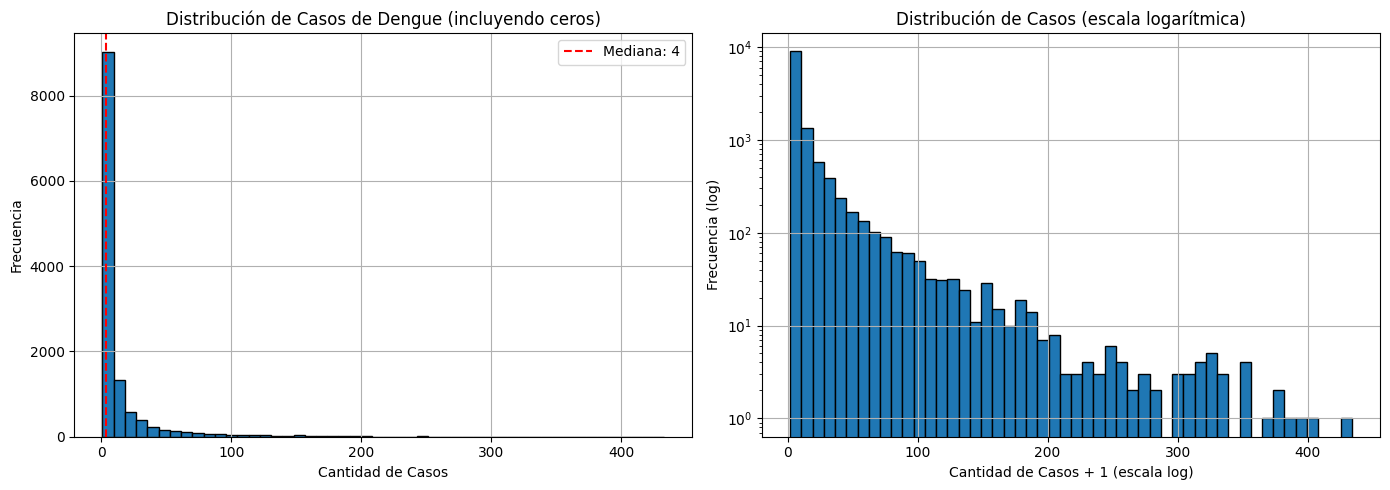

In [9]:
# Análisis de distribución de casos INCLUYENDO CEROS
print("=" * 60)
print("ANÁLISIS DE DISTRIBUCIÓN DE CASOS (INCLUYENDO CEROS)")
print("=" * 60)

# Verificar si hay ceros
ceros = (df['cantidad_casos'] == 0).sum()
print(f"\n🔍 Casos con 0 casos: {ceros:,} registros ({ceros/len(df)*100:.1f}%)")
print(f"🔍 Casos con >0 casos: {(df['cantidad_casos'] > 0).sum():,} registros ({(df['cantidad_casos'] > 0).sum()/len(df)*100:.1f}%)")

# Estadísticas completas
print("\n📊 Estadísticas (incluyendo ceros):")
print(df['cantidad_casos'].describe())

# Percentiles específicos
percentiles = [10, 25, 50, 75, 90, 95, 99]
print("\n📈 Percentiles:")
for p in percentiles:
    valor = df['cantidad_casos'].quantile(p/100)
    print(f"  {p}%: {valor:.0f} casos")

# Distribución de valores INCLUYENDO CEROS
print("\n📋 Distribución por rangos sugeridos:")
print(f"  Casos = 0: {(df['cantidad_casos'] == 0).sum():,} registros ({(df['cantidad_casos'] == 0).sum()/len(df)*100:.1f}%)")
print(f"  Casos = 1: {(df['cantidad_casos'] == 1).sum():,} registros ({(df['cantidad_casos'] == 1).sum()/len(df)*100:.1f}%)")
print(f"  Casos 2-3: {((df['cantidad_casos'] >= 2) & (df['cantidad_casos'] <= 3)).sum():,} registros ({((df['cantidad_casos'] >= 2) & (df['cantidad_casos'] <= 3)).sum()/len(df)*100:.1f}%)")
print(f"  Casos 4-10: {((df['cantidad_casos'] >= 4) & (df['cantidad_casos'] <= 10)).sum():,} registros ({((df['cantidad_casos'] >= 4) & (df['cantidad_casos'] <= 10)).sum()/len(df)*100:.1f}%)")
print(f"  Casos 11-30: {((df['cantidad_casos'] >= 11) & (df['cantidad_casos'] <= 30)).sum():,} registros ({((df['cantidad_casos'] >= 11) & (df['cantidad_casos'] <= 30)).sum()/len(df)*100:.1f}%)")
print(f"  Casos 31+: {(df['cantidad_casos'] >= 31).sum():,} registros ({(df['cantidad_casos'] >= 31).sum()/len(df)*100:.1f}%)")

# Visualización
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
df['cantidad_casos'].hist(bins=50, edgecolor='black')
plt.xlabel('Cantidad de Casos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Casos de Dengue (incluyendo ceros)')
plt.axvline(df['cantidad_casos'].median(), color='r', linestyle='--', label=f'Mediana: {df["cantidad_casos"].median():.0f}')
plt.legend()

plt.subplot(1, 2, 2)
# Log scale para ver mejor la distribución (sumamos 1 para evitar log(0))
(df['cantidad_casos'] + 1).hist(bins=50, edgecolor='black', log=True)
plt.xlabel('Cantidad de Casos + 1 (escala log)')
plt.ylabel('Frecuencia (log)')
plt.title('Distribución de Casos (escala logarítmica)')

plt.tight_layout()
plt.show()

DISTRIBUCIÓN DE CATEGORÍAS DETALLADAS

Sin casos (0):
  0 registros (0.0%)

Muy bajo (1-2):
  5,039 registros (40.3%)

Bajo (3-5):
  2,498 registros (20.0%)

Medio-bajo (6-10):
  1,712 registros (13.7%)

Medio (11-20):
  1,300 registros (10.4%)

Medio-alto (21-40):
  913 registros (7.3%)

Alto (41-70):
  505 registros (4.0%)

Muy alto (71-150):
  400 registros (3.2%)

Extremo (151+):
  152 registros (1.2%)


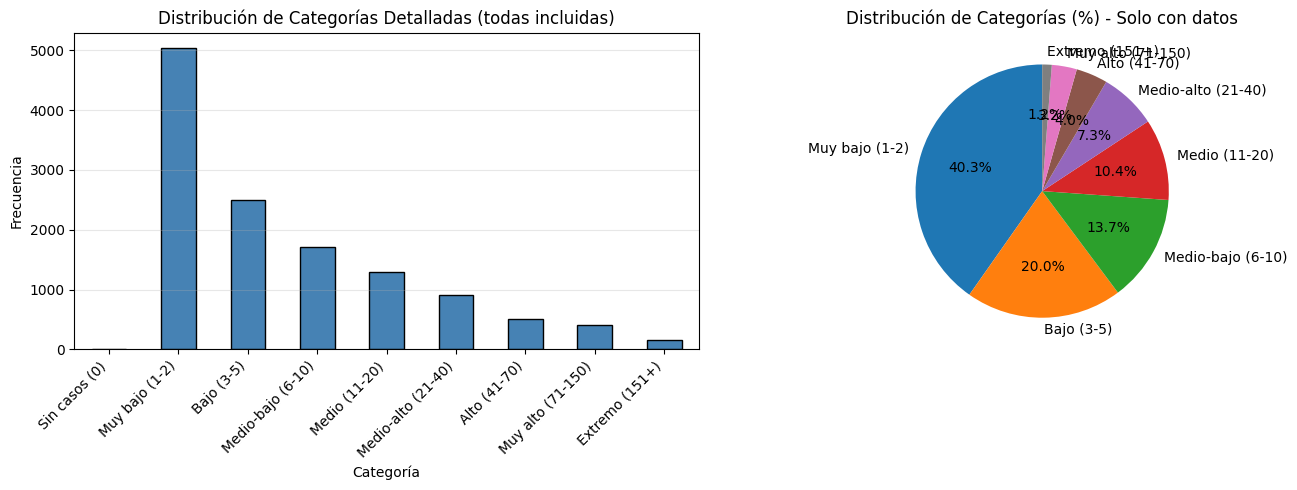


✅ Categorías detalladas creadas. Total de categorías definidas: 9 (0-8)
📊 Categorías con datos: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
📊 Rango de categorías en datos: 1 - 8


In [16]:
# Ver distribución de categorías (asegurando que todas las categorías aparezcan)
print("=" * 60)
print("DISTRIBUCIÓN DE CATEGORÍAS DETALLADAS")
print("=" * 60)

categoria_nombres = {
    0: "Sin casos (0)",
    1: "Muy bajo (1-2)",
    2: "Bajo (3-5)",
    3: "Medio-bajo (6-10)",
    4: "Medio (11-20)",
    5: "Medio-alto (21-40)",
    6: "Alto (41-70)",
    7: "Muy alto (71-150)",
    8: "Extremo (151+)"
}

# Mostrar TODAS las categorías, incluso si no tienen datos
for cat in range(9):  # 0 a 8
    count = (df['categoria_casos'] == cat).sum()
    pct = (df['categoria_casos'] == cat).sum() / len(df) * 100
    print(f"\n{categoria_nombres[cat]}:")
    print(f"  {count:,} registros ({pct:.1f}%)")

# Visualización (asegurando que todas las categorías aparezcan)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
# Crear serie con todas las categorías (0-8) para que aparezcan todas
categorias_completas = pd.Series(range(9))
conteos = categorias_completas.map(df['categoria_casos'].value_counts()).fillna(0)
conteos.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de Categorías Detalladas (todas incluidas)')
plt.xticks(range(9), [categoria_nombres[i] for i in range(9)], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
# Mostrar solo categorías que tienen datos
cats_con_datos = sorted(df['categoria_casos'].unique())
counts = [df['categoria_casos'].value_counts().sort_index()[cat] for cat in cats_con_datos]
labels = [categoria_nombres[cat] for cat in cats_con_datos]
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Categorías (%) - Solo con datos')

plt.tight_layout()
plt.show()

print(f"\n✅ Categorías detalladas creadas. Total de categorías definidas: 9 (0-8)")
print(f"📊 Categorías con datos: {sorted(df['categoria_casos'].unique())}")
print(f"📊 Rango de categorías en datos: {df['categoria_casos'].min()} - {df['categoria_casos'].max()}")

PASO 3: Rellenar dataset con todas las semanas (antes de crear lags)


In [18]:
print("=" * 60)
print("RELLENANDO DATASET CON TODAS LAS SEMANAS")
print("=" * 60)

# 1. Crear índice completo: todas las combinaciones (departamento, año, semana)
departamentos = df['id_uta'].unique()
años = df['anio'].unique()
semanas = range(1, 53)  # Semanas 1 a 52

# Crear MultiIndex completo
index_completo = pd.MultiIndex.from_product(
    [departamentos, años, semanas],
    names=['id_uta', 'anio', 'semana']
)

# Crear DataFrame completo
df_completo = pd.DataFrame(index=index_completo).reset_index()

print(f"📊 Dataset original: {len(df):,} filas")
print(f"📊 Dataset completo (todas las semanas): {len(df_completo):,} filas")
print(f"📊 Semanas faltantes a rellenar: {len(df_completo) - len(df):,}")

# 2. Hacer merge con el dataset original
# Primero, crear una clave única en ambos
df['key'] = df['id_uta'].astype(str) + '_' + df['anio'].astype(str) + '_' + df['semana'].astype(str)
df_completo['key'] = df_completo['id_uta'].astype(str) + '_' + df_completo['anio'].astype(str) + '_' + df_completo['semana'].astype(str)

# Hacer merge para traer los datos existentes
df_completo = df_completo.merge(
    df.drop(['id_uta', 'anio', 'semana'], axis=1),
    on='key',
    how='left'
)

# Eliminar la columna key temporal
df_completo = df_completo.drop('key', axis=1)

# 3. Rellenar valores faltantes
print("\n📊 Rellenando valores faltantes...")

# Ordenar por departamento, año y semana (importante para forward fill)
df_completo = df_completo.sort_values(['id_uta', 'anio', 'semana']).reset_index(drop=True)

# Identificar columnas climáticas (todas las que tienen _lag en el nombre o son variables climáticas)
columnas_clima = [col for col in df.columns if any(x in col for x in ['temperatura', 'precipitacion', 'humedad', 'rocio', 'tesion', 'radiacion', 'heliofania'])]

# Para cantidad_casos: poner 0 en las semanas faltantes
df_completo['cantidad_casos'] = df_completo['cantidad_casos'].fillna(0)
print("  ✅ cantidad_casos: semanas faltantes = 0")

# Para variables climáticas: forward fill (usar la semana más cercana anterior)
for col in columnas_clima:
    if col in df_completo.columns:
        # Forward fill por departamento
        df_completo[col] = df_completo.groupby('id_uta')[col].ffill()
        print(f"  ✅ {col}: forward fill aplicado")

# Para otras columnas que puedan faltar (población, etc.)
if 'poblacion' in df_completo.columns:
    # Población: usar la del mismo departamento (forward fill)
    df_completo['poblacion'] = df_completo.groupby('id_uta')['poblacion'].ffill()
    print("  ✅ poblacion: forward fill aplicado")

# Para metadata (departamento_nombre, provincia_nombre, id_estacion)
if 'departamento_nombre' in df_completo.columns:
    df_completo['departamento_nombre'] = df_completo.groupby('id_uta')['departamento_nombre'].ffill()
if 'provincia_nombre' in df_completo.columns:
    df_completo['provincia_nombre'] = df_completo.groupby('id_uta')['provincia_nombre'].ffill()
if 'id_estacion' in df_completo.columns:
    df_completo['id_estacion'] = df_completo.groupby('id_uta')['id_estacion'].ffill()

# 4. Recalcular categoría_casos para las nuevas filas con 0 casos
if 'categoria_casos' in df_completo.columns:
    df_completo['categoria_casos'] = df_completo['cantidad_casos'].apply(categorizar_casos_detallado)
    print("  ✅ categoria_casos: recalculada")

print("\n" + "=" * 60)
print("RESUMEN DEL DATASET RELLENADO")
print("=" * 60)
print(f"📊 Filas totales: {len(df_completo):,}")
print(f"📊 Filas con casos = 0 (rellenadas): {(df_completo['cantidad_casos'] == 0).sum():,}")
print(f"📊 Filas con casos > 0 (originales): {(df_completo['cantidad_casos'] > 0).sum():,}")

# Reemplazar df con el dataset completo
df = df_completo.copy()

print("\n✅ Dataset rellenado correctamente. Ahora podemos calcular lags.")

RELLENANDO DATASET CON TODAS LAS SEMANAS
📊 Dataset original: 12,519 filas
📊 Dataset completo (todas las semanas): 46,176 filas
📊 Semanas faltantes a rellenar: 33,657

📊 Rellenando valores faltantes...
  ✅ cantidad_casos: semanas faltantes = 0
  ✅ temperatura_minima_lag1: forward fill aplicado
  ✅ temperatura_minima_lag2: forward fill aplicado
  ✅ temperatura_minima_lag3: forward fill aplicado
  ✅ temperatura_maxima_lag1: forward fill aplicado
  ✅ temperatura_maxima_lag2: forward fill aplicado
  ✅ temperatura_maxima_lag3: forward fill aplicado
  ✅ temperatura_media_lag1: forward fill aplicado
  ✅ temperatura_media_lag2: forward fill aplicado
  ✅ temperatura_media_lag3: forward fill aplicado
  ✅ precipitacion_pluviometrica_lag1: forward fill aplicado
  ✅ precipitacion_pluviometrica_lag2: forward fill aplicado
  ✅ precipitacion_pluviometrica_lag3: forward fill aplicado
  ✅ humedad_media_lag1: forward fill aplicado
  ✅ humedad_media_lag2: forward fill aplicado
  ✅ humedad_media_lag3: forwa

PASO 3.1: Crear features adicionales agrupando por departamento, semana y año


In [20]:
print("=" * 60)
print("CREANDO FEATURES ADICIONALES")
print("=" * 60)

# 1. Separar metadata (para interpretación, no para el modelo)
metadata = df[['id_uta', 'departamento_nombre', 'provincia_nombre', 'id_estacion']].copy()

# 2. Crear densidad poblacional (tasa de incidencia)
df['densidad_casos'] = df['cantidad_casos'] / df['poblacion']
print("✅ Densidad poblacional creada (cantidad_casos / poblacion)")

# 3. Crear transformación cíclica de semana epidemiológica
# Esto hace que la semana 52 se relacione con la semana 1 (mismo punto en el círculo)
df['semana_sin'] = np.sin(2 * np.pi * df['semana'] / 52)
df['semana_cos'] = np.cos(2 * np.pi * df['semana'] / 52)
print("✅ Transformación cíclica de semana creada (seno y coseno)")
print("   → Semana 52 y semana 1 están cerca en el espacio cíclico")

# 4. IMPORTANTE: Ordenar correctamente antes de calcular lags
# Ordenar por: departamento, año, semana (en ese orden)
# Esto asegura que semana 52 de 2020 esté justo antes de semana 1 de 2021
df = df.sort_values(['id_uta', 'anio', 'semana']).reset_index(drop=True)
print("\n✅ Dataset ordenado por: id_uta → anio → semana")
print("   → Semana 52 de un año está justo antes de semana 1 del siguiente año")

# 5. Crear lags de casos de dengue (1-4 semanas)
# AGRUPAR SOLO POR id_uta (NO por año) para que los lags crucen años
# Así, semana 1 de 2021 tomará semana 52 de 2020 del mismo departamento
print("\n📊 Creando lags de casos (agrupando solo por departamento)...")
print("   → Los lags cruzan años: semana 1 de 2021 toma semana 52 de 2020")
for lag in [1, 2, 3, 4]:
    df[f'cantidad_casos_lag{lag}'] = df.groupby('id_uta')['cantidad_casos'].shift(lag)
    print(f"  ✅ Lag {lag} creado (agrupado solo por id_uta)")

# 6. Crear lag4 de variables climáticas
# Buscar todas las columnas que terminan en _lag1, _lag2, _lag3
columnas_lag = [col for col in df.columns if col.endswith('_lag1') or col.endswith('_lag2') or col.endswith('_lag3')]

# Extraer el nombre base de cada variable
variables_base = set()
for col in columnas_lag:
    if '_lag1' in col:
        variables_base.add(col.replace('_lag1', ''))
    elif '_lag2' in col:
        variables_base.add(col.replace('_lag2', ''))
    elif '_lag3' in col:
        variables_base.add(col.replace('_lag3', ''))

print("\n📊 Creando lag4 de variables climáticas (agrupando solo por departamento)...")
for var_base in sorted(variables_base):
    if f'{var_base}_lag1' in df.columns:
        # Agrupar solo por id_uta para que los lags crucen años
        df[f'{var_base}_lag4'] = df.groupby('id_uta')[f'{var_base}_lag1'].shift(3)
        print(f"  ✅ {var_base}_lag4 creado (agrupado solo por id_uta)")

print("\n" + "=" * 60)
print("RESUMEN DE FEATURES CREADAS")
print("=" * 60)
print(f"📊 Total de columnas: {len(df.columns)}")
print(f"📋 Nuevas features creadas:")
print(f"  - densidad_casos")
print(f"  - semana_sin, semana_cos (transformación cíclica)")
print(f"  - cantidad_casos_lag1, lag2, lag3, lag4 (agrupado por id_uta)")
print(f"  - Variables climáticas lag4 (agrupado por id_uta)")
print(f"\n✅ Los lags cruzan años: semana 1 de año N toma semana 52 de año N-1")
print(f"✅ La transformación cíclica relaciona semana 52 con semana 1")

# Verificar que los lags están correctos (ejemplo con un departamento)
print("\n📊 Verificación de lags (ejemplo con un departamento):")
# Buscar un departamento que tenga datos en diferentes años
ejemplo = df[df['id_uta'] == df['id_uta'].iloc[0]].sort_values(['anio', 'semana'])
# Mostrar las últimas semanas de un año y primeras del siguiente
ultimas_semanas = ejemplo[ejemplo['semana'] >= 50].head(5)
primeras_semanas = ejemplo[ejemplo['semana'] <= 3].head(5)
verificacion = pd.concat([ultimas_semanas, primeras_semanas])[['id_uta', 'anio', 'semana', 'cantidad_casos', 'cantidad_casos_lag1', 'cantidad_casos_lag2']]
print(verificacion.to_string())

print("\n✅ Features creadas correctamente")
print("   → Lags agrupados por departamento (cruzan años)")
print("   → Transformación cíclica relaciona temporadas")

CREANDO FEATURES ADICIONALES
✅ Densidad poblacional creada (cantidad_casos / poblacion)
✅ Transformación cíclica de semana creada (seno y coseno)
   → Semana 52 y semana 1 están cerca en el espacio cíclico

✅ Dataset ordenado por: id_uta → anio → semana
   → Semana 52 de un año está justo antes de semana 1 del siguiente año

📊 Creando lags de casos (agrupando solo por departamento)...
   → Los lags cruzan años: semana 1 de 2021 toma semana 52 de 2020
  ✅ Lag 1 creado (agrupado solo por id_uta)
  ✅ Lag 2 creado (agrupado solo por id_uta)
  ✅ Lag 3 creado (agrupado solo por id_uta)
  ✅ Lag 4 creado (agrupado solo por id_uta)

📊 Creando lag4 de variables climáticas (agrupando solo por departamento)...
  ✅ cantidad_casos_lag4 creado (agrupado solo por id_uta)
  ✅ heliofania_efectiva_lag4 creado (agrupado solo por id_uta)
  ✅ heliofania_relativa_lag4 creado (agrupado solo por id_uta)
  ✅ humedad_media_lag4 creado (agrupado solo por id_uta)
  ✅ precipitacion_pluviometrica_lag4 creado (agrupa

Paso 4: Preparar datos para el modelo

In [23]:
print("=" * 60)
print("PREPARANDO DATOS PARA EL MODELO")
print("=" * 60)

# 1. Separar metadata (no se usan como features, solo para interpretación)
metadata = df[['id_uta', 'departamento_nombre', 'provincia_nombre', 'id_estacion', 'anio', 'semana']].copy()

# 2. Separar target (lo que queremos predecir)
target = df['categoria_casos'].copy()
print(f"✅ Target separado: categoria_casos")
print(f"   Distribución: {target.value_counts().sort_index().to_dict()}")

# 3. Identificar features (variables que el modelo usará)
# Excluir: metadata, target, cantidad_casos (es el target original, no la categoría)
columnas_excluir = [
    'id_uta', 'departamento_nombre', 'provincia_nombre', 'id_estacion',
    'anio', 'semana',  # Temporales (ya tenemos semana_sin y semana_cos)
    'cantidad_casos', 'categoria_casos'  # Targets
]

# Todas las demás columnas son features
features = df.drop(columnas_excluir, axis=1)

print(f"\n✅ Features identificadas: {len(features.columns)} columnas")
print(f"\n📋 Lista de features:")
for i, col in enumerate(features.columns, 1):
    print(f"  {i:2d}. {col}")

# 4. Manejar valores nulos en los lags
# Los lags tienen NaN al inicio de cada departamento (normal)
# Opciones: eliminar filas con NaN o imputar con 0
print(f"\n📊 Valores nulos en features:")
nulos_por_col = features.isnull().sum()
nulos_por_col = nulos_por_col[nulos_por_col > 0].sort_values(ascending=False)
if len(nulos_por_col) > 0:
    print(nulos_por_col)
    print(f"\n💡 Opción: Eliminar filas con NaN en lags (son las primeras semanas de cada departamento)")
    print(f"   Filas antes: {len(features):,}")
    # Eliminar filas donde cualquier lag esté NaN
    mask_sin_nulos = ~features.filter(like='lag').isnull().any(axis=1)
    features = features[mask_sin_nulos].copy()
    target = target[mask_sin_nulos].copy()
    metadata = metadata[mask_sin_nulos].copy()
    print(f"   Filas después: {len(features):,}")
    print(f"   Filas eliminadas: {(~mask_sin_nulos).sum():,}")
else:
    print("   ✅ No hay valores nulos")

# 5. Verificar que todo está alineado
print(f"\n✅ Verificación final:")
print(f"   Features: {len(features):,} filas × {len(features.columns)} columnas")
print(f"   Target: {len(target):,} filas")
print(f"   Metadata: {len(metadata):,} filas")
print(f"   ¿Están alineados? {len(features) == len(target) == len(metadata)}")

# 6. Ver distribución del target después de limpiar
print(f"\n📊 Distribución del target (después de limpiar):")
distribucion = target.value_counts().sort_index()
for cat, count in distribucion.items():
    pct = count / len(target) * 100
    print(f"   Categoría {cat}: {count:,} ({pct:.1f}%)")

print("\n✅ Datos preparados para el modelo")

PREPARANDO DATOS PARA EL MODELO
✅ Target separado: categoria_casos
   Distribución: {0: 42396, 1: 5039, 2: 2498, 3: 1712, 4: 1300, 5: 913, 6: 505, 7: 400, 8: 152}

✅ Features identificadas: 48 columnas

📋 Lista de features:
   1. poblacion
   2. temperatura_minima_lag1
   3. temperatura_minima_lag2
   4. temperatura_minima_lag3
   5. temperatura_maxima_lag1
   6. temperatura_maxima_lag2
   7. temperatura_maxima_lag3
   8. temperatura_media_lag1
   9. temperatura_media_lag2
  10. temperatura_media_lag3
  11. precipitacion_pluviometrica_lag1
  12. precipitacion_pluviometrica_lag2
  13. precipitacion_pluviometrica_lag3
  14. humedad_media_lag1
  15. humedad_media_lag2
  16. humedad_media_lag3
  17. rocio_medio_lag1
  18. rocio_medio_lag2
  19. rocio_medio_lag3
  20. tesion_vapor_media_lag1
  21. tesion_vapor_media_lag2
  22. tesion_vapor_media_lag3
  23. radiacion_global_lag1
  24. radiacion_global_lag2
  25. radiacion_global_lag3
  26. heliofania_efectiva_lag1
  27. heliofania_efectiva_l